In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape, Input, Flatten, BatchNormalization
from sklearn.model_selection import train_test_split

In [2]:
import time, datetime
from fyers_apiv3 import fyersModel
import authenticator
client_id = "ZHQ4IJL7TI-100"
access_token = authenticator.authenticate()

fyers = fyersModel.FyersModel(client_id=client_id, is_async=False, token=access_token, log_path="")
market_status = fyers.market_status()

"Market: " + market_status["marketStatus"][1]['status']

'Market: CLOSED'

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from indicators.syncind import SyncInd
from indicators.classic import SMA, Alligator, SmoothMA, RSI, MACD, ATR, WMA, EMA, RMA, VolumeROC, KAMA
from indicators.candle import OHLC
from indicators import epoch_to_time

In [5]:
date_yesterday = (datetime.datetime.now() - datetime.timedelta(days=1)).strftime("%Y-%m-%d")
date_100_p = (datetime.datetime.now() - datetime.timedelta(days=100)).strftime("%Y-%m-%d")
date_yesterday, date_100_p

('2025-02-22', '2024-11-15')

In [6]:
symbol = "NSE:NIFTY50-INDEX"
resolution_1 = "1"
resolution_2 = "5"

response_1 = fyers.history(data={
                                "symbol": symbol,
                                "resolution": resolution_1,
                                "date_format": "1",
                                "range_from": date_100_p,
                                "range_to": date_yesterday,
                                "cont_flag": "1"
                        })

response_2 = fyers.history(data={
                                "symbol": symbol,
                                "resolution": resolution_2,
                                "date_format": "1",
                                "range_from": date_100_p,
                                "range_to": date_yesterday,
                                "cont_flag": "1"
                        })

len(response_1['candles']), len(response_2['candles'])

(25875, 5175)

In [7]:
date_temp = []
final_candles_list_1 = []
for i in response_1['candles']:
    if i[0] not in date_temp:
        final_candles_list_1.append(i)
        date_temp.append(i[0])
del date_temp
len(final_candles_list_1)

25875

In [8]:
date_temp = []
final_candles_list_2 = []
for i in response_2['candles']:
    if i[0] not in date_temp:
        final_candles_list_2.append(i)
        date_temp.append(i[0])
del date_temp
len(final_candles_list_2)

5175

In [9]:
candles_1 = np.array(final_candles_list_1)
candles_1.shape

(25875, 6)

In [10]:
candles_2 = np.array(final_candles_list_2)
candles_2.shape

(5175, 6)

In [11]:
sync_1 = SyncInd(
    # Alligator(show_jaw=False, show_teeth=False),
    # KAMA(highlight=True),
    # SMA(5),
)

for c in candles_1:
    sync_1.append(c)
sync_1.data().shape

(25875, 6)

In [12]:
sync_2 = SyncInd(
    # Alligator(show_jaw=False, show_teeth=False),
    # KAMA(highlight=True),
    # SMA(5),
)

for c in candles_2:
    sync_2.append(c)
sync_2.data().shape

(5175, 6)

In [43]:
X, y = [], []
prev_ind = 0

data1 = sync_1.data()
data5 = sync_2.data()

max_dev = 5

avg = []

for ind, i in enumerate(data5):
    first_open = i[1]
    first_close = i[4]
    avg_cnd_bg = (first_open + first_close) / 2
    try:
        if data5[ind+1][4] >= avg_cnd_bg:
            y.append([1])
            print(ind)
        else:
            y.append([0])
    except Exception as es:
        
        continue
    # print(first_open)
    super_temp = []
    for j in range(int(resolution_2)):
        try:
            temp = []
            temp.append(data1[prev_ind + j][1:] - first_open)
            temp = temp[0].tolist()
            temp.pop(4)
            super_temp.append(temp)
            
            if max_dev < max(temp):
                pass
                # print(ind)
        except Exception as es:
            pass
    X.append(super_temp)
        
    prev_ind += (int(resolution_2) )
    # print(prev_ind)


X, y = np.array(X, dtype=np.float16), np.array(y, dtype=np.float16)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

5
6
8
9
12
18
19
22
23
24
25
28
29
30
31
32
33
34
35
37
38
40
41
45
50
51
54
55
57
63
64
65
66
70
71
73
74
75
76
77
78
79
83
84
87
88
90
94
95
96
97
99
100
101
102
103
104
107
110
113
114
116
117
118
119
120
121
122
125
126
128
129
130
134
138
147
151
154
156
157
158
162
163
167
168
170
171
172
173
175
176
178
179
180
181
182
185
187
189
194
195
196
197
198
199
200
203
204
205
209
210
214
216
217
219
220
222
224
225
226
227
231
232
233
234
239
240
243
244
245
247
250
251
252
253
255
256
257
258
259
261
262
263
264
265
266
269
270
271
272
273
276
277
278
279
280
281
282
284
285
287
290
291
292
294
299
300
301
308
309
311
312
313
314
316
317
320
321
323
332
333
334
337
339
340
346
347
348
349
350
355
356
357
358
359
361
362
363
364
365
369
370
371
372
373
374
377
383
384
388
390
391
393
394
395
400
401
402
403
409
414
415
416
417
418
421
422
423
428
429
430
431
434
435
437
438
439
441
442
445
448
449
455
456
459
460
465
466
469
470
471
474
475
477
478
481
482
483
484
485
486
487
488
489


In [14]:
model = Sequential([
    tf.keras.Input((5, 4)),
    LSTM(128, return_sequences=True),  # LSTM layer to learn temporal dependencies
    Dropout(0.2),  # Regularization to prevent overfitting
    LSTM(64, return_sequences=False),  # Second LSTM layer
    Dropout(0.2),
    Dense(32, activation='relu'),  # Fully connected layer
    Dense(16, activation='relu'),
    Dense(1)  # Output layer for regression or binary classification
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # Mean squared error for regression

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 128)         │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,129 (469.25 KB)

 Trainable params: 120,129 (469.25 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/200
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2854 - mae: 0.4612 - val_loss: 0.2183 - val_mae: 0.4361
Epoch 2/200
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2246 - mae: 0.4357 - val_loss: 0.2175 - val_mae: 0.4424
Epoch 3/200
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2237 - mae: 0.4407 - val_loss: 0.2173 - val_mae: 0.4206
Epoch 4/200
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2194 - mae: 0.4339 - val_loss: 0.2152 - val_mae: 0.4295
Epoch 5/200
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2178 - mae: 0.4276 - val_loss: 0.2153 - val_mae: 0.4355
Epoch 6/200
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2207 - mae: 0.4360 - val_loss: 0.2150 - val_mae: 0.4201
Epoch 7/200
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2175 - mae: 0.4285 - val_loss: 0.2143 - val_mae: 0.4350
Epoch 8/200
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2187 - mae: 0.4351 - val_loss: 0.2156 - val_mae: 0.4314
Epoch 9/200
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/

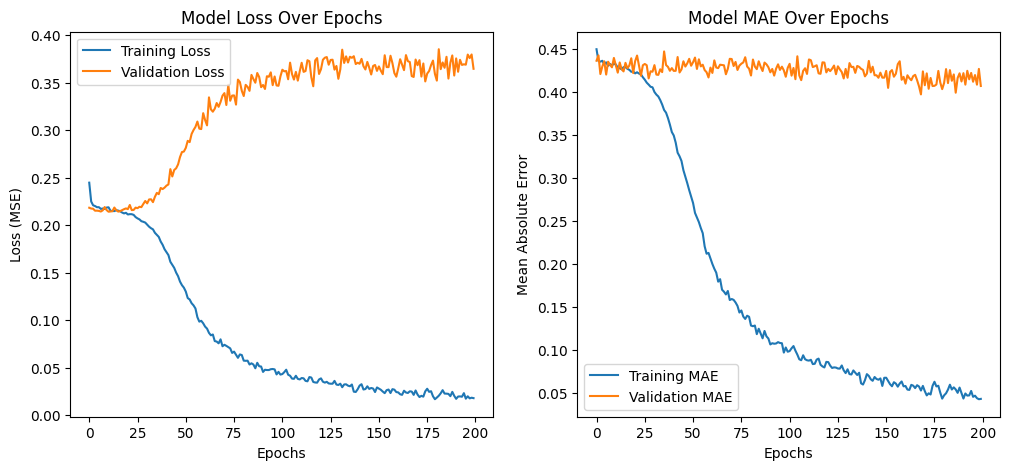

In [16]:
# Plot loss and validation loss
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model Loss Over Epochs')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('Model MAE Over Epochs')
plt.legend()

plt.show()

In [53]:
k = 5

if float(model.predict(X_val[k:k+2])[0]) > 0.7: 
    print(1 == int(y_val[k:k+2][0]))
else:
    print(0 == int(y_val[k:k+2][0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
False


/var/folders/4_/khzxtjkx373803xbyhfqy0cw0000gn/T/ipykernel_4018/2175313741.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if float(model.predict(X_val[k:k+2])[0]) > 0.7:
/var/folders/4_/khzxtjkx373803xbyhfqy0cw0000gn/T/ipykernel_4018/2175313741.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(0 == int(y_val[k:k+2][0]))


In [78]:
pred = []
for i in model.predict(X_val):
    if i > 0.9:
        pred.append(1)
    else:
        pred.append(0)
        

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


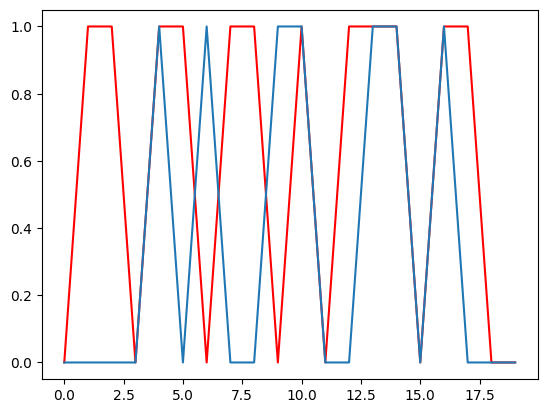

In [82]:
start, end = 100, 120
plt.figure()
plt.plot(pred[start: end], label='Prediction', color="red")
plt.plot(y_val.tolist()[start: end], label='Actual')
# plt.xlabel('Epochs')
# plt.ylabel('Loss (MSE)')
plt.show()